In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

import mne
from mne.datasets.sleep_physionet.age import fetch_data

In [15]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5 * n_channels]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {
        "delta": [0.5, 4.5],
        "theta": [4.5, 8.5],
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }

    spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
    psds, freqs = spectrum.get_data(return_freqs=True)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

In [9]:
files = [
    "D:/Intercranial_sleep_data/2/iEEG/converted/2_night1_01.vhdr",
    "D:/Intercranial_sleep_data/2/iEEG/converted/2_night1_02.vhdr",
    "D:/Intercranial_sleep_data/2/iEEG/converted/2_night1_03.vhdr"
]

raw_list = [mne.io.read_raw_brainvision(f, preload=True) for f in files]

raw = mne.concatenate_raws(raw_list)
raw.set_channel_types({
    'C3-Cz':'eeg',
    'Oz-Cz':'eeg',
    'EOG1-EOG2':'eog',
    'EMG1-EMG2':'emg'
})

Extracting parameters from D:/Intercranial_sleep_data/2/iEEG/converted/2_night1_01.vhdr...
Setting channel info structure...
Reading 0 ... 3596783  =      0.000 ... 14387.132 secs...
Extracting parameters from D:/Intercranial_sleep_data/2/iEEG/converted/2_night1_02.vhdr...
Setting channel info structure...
Reading 0 ... 3599951  =      0.000 ... 14399.804 secs...
Extracting parameters from D:/Intercranial_sleep_data/2/iEEG/converted/2_night1_03.vhdr...
Setting channel info structure...
Reading 0 ... 3599871  =      0.000 ... 14399.484 secs...


<RawBrainVision | 2_night1_01.dat, 4 x 10796608 (43186.4 s), ~329.5 MiB, data loaded>

In [10]:
scores_files = [
    "D:/Intercranial_sleep_data/2/iEEG/converted/edf_files/2_night1_01_hypnogram.npy",
    "D:/Intercranial_sleep_data/2/iEEG/converted/edf_files/2_night1_02_hypnogram.npy",
    "D:/Intercranial_sleep_data/2/iEEG/converted/edf_files/2_night1_03_hypnogram.npy"
]

score_list = [np.load(f) for f in scores_files]
hypno = np.concatenate(score_list)
hypno = hypno.astype(int)
eeg_duration = raw.n_times / raw.info['sfreq']
n_epochs = int(eeg_duration // (30))  # assuming 30s epochs
hypno = hypno[:n_epochs]            # crop to EEG length if needed
stage_mapping = {0: "Wake", 1: "N1", 2: "N2", 3: "N3", 4: "REM"}
description = [stage_mapping[s] for s in hypno]
onset = np.arange(len(hypno)) * 30  # 30s per epoch
duration = np.repeat(30, len(hypno))
#
annotations = mne.Annotations(onset, duration, description)
raw.set_annotations(annotations)

<RawBrainVision | 2_night1_01.dat, 4 x 10796608 (43186.4 s), ~329.5 MiB, data loaded>

In [11]:
events, event_id = mne.events_from_annotations(raw)
print("Event dict:", event_id)
tmax = 30.0 - 1.0 / raw.info["sfreq"]  # one 30s epoch
epochs = mne.Epochs(
    raw=raw,
    events=events,
    event_id=event_id,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
    detrend=1,
    preload=True,
)

Used Annotations descriptions: [np.str_('N1'), np.str_('N2'), np.str_('N3'), np.str_('REM'), np.str_('Wake')]
Event dict: {np.str_('N1'): 10001, np.str_('N2'): 10002, np.str_('N3'): 10003, np.str_('REM'): 10004, np.str_('Wake'): 10005}
Not setting metadata
1439 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1439 events and 7500 original time points ...
0 bad epochs dropped


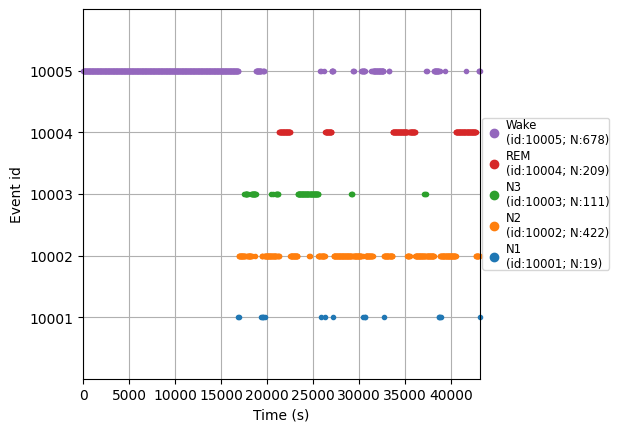

In [12]:
fig = mne.viz.plot_events(
    events,
    sfreq=raw.info["sfreq"],
    first_samp=raw.first_samp,
    event_id=event_id,   # 👈 ensures y-axis has stage labels
)

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


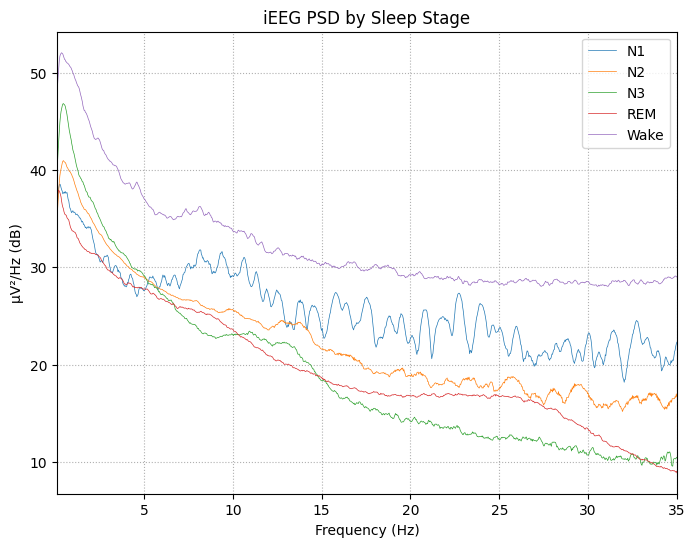

In [14]:
stages = sorted(event_id.keys())
stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig, ax = plt.subplots(figsize=(8, 6))

for stage, color in zip(stages, stage_colors):
    spectrum = epochs[stage].compute_psd(fmin=0.1, fmax=35.0)
    spectrum.plot(
        ci=None,
        color=color,
        axes=ax,
        show=False,
        average=True,
        amplitude=False,
        spatial_colors=False,
        picks="data",   # or "seeg" since this is intracranial
        exclude="bads",
    )

ax.set(
    title="iEEG PSD by Sleep Stage",
    xlabel="Frequency (Hz)",
    ylabel="µV²/Hz (dB)",
)
ax.legend(ax.lines[2::3], stages)

plt.show()

In [ ]:
pipe = make_pipeline(
    FunctionTransformer(eeg_power_band, validate=False),
    RandomForestClassifier(n_estimators=100, random_state=42),
)

# Train
y_train = epochs.events[:, 2]
pipe.fit(epochs_train, y_train)

# Test
y_pred = pipe.predict(epochs_test)

# Assess the results
y_test = epochs_test.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy score: {acc}")